# Notebook #5

## Computing the true X-ray luminosity

In [86]:
import sys
sys.path.append("./utils")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

from matplotlib import cm
from scipy.interpolate import interp1d
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

from data_loader import DataLoader
from config_loader import ConfigLoader
from sed_utils import SEDUtils

In [87]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
config = ConfigLoader("/Users/admin/Documents/GitHub/matched-catalog-analysis/src/configs/config.yaml")
sed = SEDUtils

data_output_path = "/Users/admin/Documents/GitHub/Matched-Catalog-Analysis/src/data_final"

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['legend.fontsize'] = 16

edff_color = '#e46868'
erosita_color = '#3d7cdc'
cdfs_color = '#6ead50'

edff_cdfs = pd.read_csv(config.EDFF_CDFS_PATH)
edff_erosita = pd.read_csv(config.EDFF_EROSITA_PATH)

In [88]:
print("Length: ", len(edff_cdfs))
edff_cdfs = edff_cdfs[
    (edff_cdfs['zspec'] > 0) 
    &(edff_cdfs['FSB'] > 0)
]
print("Length: ", len(edff_cdfs))
edff_cdfs.head()

Length:  656
Length:  468


,OutID,InID,Rel,LR,flag,ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_NB0816_MAG,HSC_NB0816_MAGERR,HSC_NB0816_FLUX,HSC_NB0816_FLUXERR,HSC_NB0816_CHISQ,HSC_NB0816_DRIFT,HSC_NB0816_VALID,HSC_NB0921_MAG,HSC_NB0921_MAGERR,HSC_NB0921_FLUX,HSC_NB0921_FLUXERR,HSC_NB0921_CHISQ,HSC_NB0921_DRIFT,HSC_NB0921_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp_chiq,lp_modq,lp_mods,lp_chis,lp_model,lp_age,lp_dust,lp_Attenuation,lp_MNUV,lp_MR,lp_MJ,lp_mass_med,lp_mass_med_min68,lp_mass_med_max68,lp_mass_best,lp_SFR_med,lp_SFR_med_min68,lp_SFR_med_max68,lp_SFR_best,lp_sSFR_med,lp_sSFR_med_min68,lp_sSFR_med_max68,lp_sSFR_best,ez_z_phot,ez_z_phot_chi2,ez_z_phot_risk,ez_z_min_risk,ez_min_risk,ez_z_raw_chi2,ez_raw_chi2,ez_z_ml,ez_z_ml_chi2,ez_z_ml_risk,ez_z025,ez_z160,ez_z500,ez_z840,ez_z975,ez_nusefilt,ez_lc_min,ez_lc_max,ez_star_min_chi2,ez_star_teff,Seq,RAJ2000,DEJ2000,logPB,WAV,errPos,Angle,FB,e_FB,e_fb_lc,SB,e_SB,e_sb_lc,HB,e_HB,e_hb_lc,Ph,CPCat,CPoff,CPNote,RAWdeg,DEWdeg,RmagW,RAGSdeg,DEGSdeg,zmagGS,RAGdeg,DEGdeg,zmagG,RACdeg,DECdeg,F125Wmag,RATdeg,DETdeg,KsmagT,RASdeg,DESdeg,_3_6mag,RAVdeg,DEVdeg,VLAmag,zspec,q_zspec,r_zspec,zL10,zR11,zH14,zS14,zS15,zS16,zF,r_zF,e_zF,e_zf_lc,FExp,SExp,HExp,BR,e_BR,e_br_lc,Gamma,e_Gamma,e_gamma_lc,FFB,FSB,FHB,LX,NH,LXc,OType,f_X11ID,X11ID,f_X16ID,X16ID,R13ID,recno
0,0,458822,0.997,14.450,1.0,458823,52.899085,-27.859726,20621.585139,17170.794960,0.003822,0.004051,52.899084,-27.859724,55_9804,6672,1,0.0,ExpGalaxy,0.007664,1.611016,0.013837,23.382250,0.009353,0.898824,0.017911,True,3.810336,0.010238,22.447592,0.002926,1.017300,0.027875,True,2.952419,0.006897,22.724555,0.002544,1.556026,0.003955,True,4.174383,0.008332,22.348519,0.002174,2.399218,0.002706,True,5.360851,0.043437,22.076916,0.008824,1.095089,0.023550,True,22.159055,0.017409,4.970246,0.079456,0.912490,0.009173,True,22.209646,0.009310,4.743968,0.040558,1.143135,0.011625,True,19.968416,0.013417,20.649141,0.000732,263.911946,0.139119,True,25.495188,0.020691,20.383854,0.000884,358.910830,0.076751,True,2.0269,1.9673,2.0954,2.0760,56.07560,NaN,NaN,7,2.36,60.5269,23,240,1573.160,5,8.064000e+08,0.2,0,-22.36209,-23.86975,-24.15572,10.85561,10.79791,10.91246,10.86241,2.10018,2.03206,2.16818,2.0970,-8.75609,-8.84821,-8.66402,-8.765,1.970717,44.655087,0.008678,1.959440,0.008256,2.004166,4.398533e+01,1.996703,4.396116e+01,0.014285,1.869814,1.914355,1.970717,1.996113,2.007755,7,3640.981999,45020.337852,928.44850,6500.0,1,52.899178,-27.859588,0.0,-8,0.53,12.04,886.7,38.2,39.3,604.3,28.2,29.4,282.9,26.1,27.3,E,GEMS,0.52,,52.899048,-27.859669,21.97,0.0,0.0,0.0,52.899028,-27.859646,22.27,0.0,0.0,0.0,52.899017,-27.859646,20.70,52.899053,-27.859624,20.25,0.0,0.0,0.0,1.628,Secure,16,1.63,1.64,1.62,0.0,0.0,0.0,1.628,zSpec,0.0,0.0,120000.0,110000.0,130000.0,0.374,0.038,0.040,1.78,0.10,0.11,2.400000e-14,1.100000e-14,1.300000e-14,3.600000e+44,8.900000e+20,3.800000e+44,AGN,,1,,127,1059,1
2,2,432521,1.000,127.600,1.0,432522,52.917198,-27.796322,20278.546181,18529.548059,0.002460,0.002386,52.917196,-27.796321,56_1901,974,6,0.0,ExpGalaxy,0.007767,3.546491,0.011104,22.525503,0.003410,1.966725,0.060761,True,3.993926,0.009144,22.396500,0.002493,1.529157,0.032150,True,6.764130,0.007958,21.824470,0

In [89]:
print("Length: ", len(edff_erosita))
edff_erosita = edff_erosita[
    (edff_erosita['ML_FLUX_P2'] > 0) &
    (edff_erosita['ML_FLUX_P3'] > 0)
]
print("Length: ", len(edff_erosita))
edff_erosita.head()

Length:  53
Length:  51


,OutID,InID,Rel,LR,flag,ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_NB0816_MAG,HSC_NB0816_MAGERR,HSC_NB0816_FLUX,HSC_NB0816_FLUXERR,HSC_NB0816_CHISQ,HSC_NB0816_DRIFT,HSC_NB0816_VALID,HSC_NB0921_MAG,HSC_NB0921_MAGERR,HSC_NB0921_FLUX,HSC_NB0921_FLUXERR,HSC_NB0921_CHISQ,HSC_NB0921_DRIFT,HSC_NB0921_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp_chiq,lp_modq,lp_mods,lp_chis,lp_model,lp_age,lp_dust,lp_Attenuation,lp_MNUV,lp_MR,lp_MJ,lp_mass_med,lp_mass_med_min68,lp_mass_med_max68,lp_mass_best,lp_SFR_med,lp_SFR_med_min68,lp_SFR_med_max68,lp_SFR_best,lp_sSFR_med,lp_sSFR_med_min68,lp_sSFR_med_max68,lp_sSFR_best,ez_z_phot,ez_z_phot_chi2,ez_z_phot_risk,ez_z_min_risk,ez_min_risk,ez_z_raw_chi2,ez_raw_chi2,ez_z_ml,ez_z_ml_chi2,ez_z_ml_risk,ez_z025,ez_z160,ez_z500,ez_z840,ez_z975,ez_nusefilt,ez_lc_min,ez_lc_max,ez_star_min_chi2,ez_star_teff,IAUNAME,DETUID,SKYTILE,ID_SRC,UID,UID_Hard,ID_CLUSTER,RA,DEC,RA_RAW,DEC_RAW,RA_LOWERR,RA_UPERR,DEC_LOWERR,DEC_UPERR,POS_ERR,RADEC_ERR,LII,BII,ELON,ELAT,MJD,MJD_MIN,MJD_MAX,EXT,EXT_ERR,EXT_LOWERR,EXT_UPERR,EXT_LIKE,DET_LIKE_0,ML_CTS_1,ML_CTS_ERR_1,ML_CTS_LOWERR_1,ML_CTS_UPERR_1,ML_RATE_1,ML_RATE_ERR_1,ML_RATE_LOWERR_1,ML_RATE_UPERR_1,ML_FLUX_1,ML_FLUX_ERR_1,ML_FLUX_LOWERR_1,ML_FLUX_UPERR_1,ML_BKG_1,ML_EXP_1,ML_EEF_1,APE_CTS_1,APE_BKG_1,APE_EXP_1,APE_RADIUS_1,APE_POIS_1,DET_LIKE_P1,ML_CTS_P1,ML_CTS_ERR_P1,ML_CTS_LOWERR_P1,ML_CTS_UPERR_P1,ML_RATE_P1,ML_RATE_ERR_P1,ML_RATE_LOWERR_P1,ML_RATE_UPERR_P1,ML_FLUX_P1,ML_FLUX_ERR_P1,ML_FLUX_LOWERR_P1,ML_FLUX_UPERR_P1,ML_BKG_P1,ML_EXP_P1,ML_EEF_P1,APE_CTS_P1,APE_BKG_P1,APE_EXP_P1,APE_RADIUS_P1,APE_POIS_P1,DET_LIKE_P2,ML_CTS_P2,ML_CTS_ERR_P2,ML_CTS_LOWERR_P2,ML_CTS_UPERR_P2,ML_RATE_P2,ML_RATE_ERR_P2,ML_RATE_LOWERR_P2,ML_RATE_UPERR_P2,ML_FLUX_P2,ML_FLUX_ERR_P2,ML_FLUX_LOWERR_P2,ML_FLUX_UPERR_P2,ML_BKG_P2,ML_EXP_P2,ML_EEF_P2,APE_CTS_P2,APE_BKG_P2,APE_EXP_P2,APE_RADIUS_P2,APE_POIS_P2,DET_LIKE_P3,ML_CTS_P3,ML_CTS_ERR_P3,ML_CTS_LOWERR_P3,ML_CTS_UPERR_P3,ML_RATE_P3,ML_RATE_ERR_P3,ML_RATE_LOWERR_P3,ML_RATE_UPERR_P3,ML_FLUX_P3,ML_FLUX_ERR_P3,ML_FLUX_LOWERR_P3,ML_FLUX_UPERR_P3,ML_BKG_P3,ML_EXP_P3,ML_EEF_P3,APE_CTS_P3,APE_BKG_P3,APE_EXP_P3,APE_RADIUS_P3,APE_POIS_P3,DET_LIKE_P4,ML_CTS_P4,ML_CTS_ERR_P4,ML_CTS_LOWERR_P4,ML_CTS_UPERR_P4,ML_RATE_P4,ML_RATE_ERR_P4,ML_RATE_LOWERR_P4,ML_RATE_UPERR_P4,ML_FLUX_P4,ML_FLUX_ERR_P4,ML_FLUX_LOWERR_P4,ML_FLUX_UPERR_P4,ML_BKG_P4,ML_EXP_P4,ML_EEF_P4,APE_CTS_P4,APE_BKG_P4,APE_EXP_P4,APE_RADIUS_P4,APE_POIS_P4,DET_LIKE_P5,ML_CTS_P5,ML_CTS_ERR_P5,ML_CTS_LOWERR_P5,ML_CTS_UPERR_P5,ML_RATE_P5,ML_RATE_ERR_P5,ML_RATE_LOWERR_P5,ML_RATE_UPERR_P5,ML_FLUX_P5,ML_FLUX_ERR_P5,ML_FLUX_LOWERR_P5,ML_FLUX_UPERR_P5,ML_BKG_P5,ML_EXP_P5,ML_EEF_P5,APE_CTS_P5,APE_BKG_P5,APE_EXP_P5,APE_RADIUS_P5,APE_POIS_P5,DET_LIKE_P6,ML_CTS_P6,ML_CTS_ERR_P6,ML_CTS_LOWERR_P6,ML_CTS_UPERR_P6,ML_RATE_P6,ML_RATE_ERR_P6,ML_RATE_LOWERR_P6,ML_RATE_UPERR_P6,ML_FLUX_P6,ML_FLUX_ERR_P6,ML_FLUX_LOWERR_P6,ML_FLUX_UPERR_P6,ML_BKG_P6,ML_EXP_P6,ML_EEF_P6,APE_CTS_P6,APE_BKG_P6,APE_EXP_P6,APE_RADIUS_P6,APE_POIS_P6,DET_LIKE_P7,ML_CTS_P7,ML_CTS_ERR_P7,ML_CTS_LOWERR_P7,ML_CTS_UPERR_P7,ML_RATE_P7,ML_RATE_ERR_P7,ML_RATE_LOWERR_P7,ML_RATE_UPERR_P7,ML_FLUX_P7,ML_FLUX_ERR_P7,ML_FLUX_LOWERR_P7,ML_FLUX_UPERR_P7,ML_BKG_P7,M

## Computing Fluxes and Luminosities

In [90]:
#in Angstroms
LAMBDA_MID_X = (6.19 + 24.80 ) / 2 
LAMBDA_MID_U = (3147.51	+ 4018.39) / 2
LAMBDA_MID_G = (3942.85 + 5547.08) / 2
LAMBDA_MID_R2 = (5021.21 + 7216.76) / 2
LAMBDA_MID_I = (6440.47 + 8643.90) / 2
LAMBDA_MID_Z = (8564.13 + 9490.57) / 2
LAMBDA_MID_CH1 = (31296.24 + 39614.36) / 2
LAMBDA_MID_CH2 = (39173.28 + 50560.57) / 2

wavelength_dict = {
    'LAMBDA_MID_X': LAMBDA_MID_X,
    'LAMBDA_MID_U': LAMBDA_MID_U,
    'LAMBDA_MID_G': LAMBDA_MID_G,
    'LAMBDA_MID_R2': LAMBDA_MID_R2,
    'LAMBDA_MID_I': LAMBDA_MID_I,
    'LAMBDA_MID_Z': LAMBDA_MID_Z,
    'LAMBDA_MID_CH1': LAMBDA_MID_CH1,
    'LAMBDA_MID_CH2': LAMBDA_MID_CH2
}

wavelengths = [
    LAMBDA_MID_X, 
    LAMBDA_MID_U, 
    LAMBDA_MID_G, 
    LAMBDA_MID_R2, 
    LAMBDA_MID_I,
    LAMBDA_MID_Z,
    LAMBDA_MID_CH1,
    LAMBDA_MID_CH2
]

edff_magnitude_columns = [
    'CFHT_u_MAG', 'HSC_g_MAG', 'HSC_r_MAG', 
    'HSC_i_MAG', 'HSC_z_MAG', 'IRAC_CH1_MAG', 
    'IRAC_CH2_MAG'
]
flux_column_names = [
    'F_u', 'F_g', 'F_r', 
    'F_i', 'F_z', 'F_ch1', 
    'F_ch2'
]
luminosity_column_names = [
    'L_u', 'L_g', 'L_r', 
    'L_i', 'L_z', 'L_ch1', 
    'L_ch2'
]

edff_cdfs_computed = pd.DataFrame({
    'edffID': edff_cdfs['InID'], 
    'z': edff_cdfs['zspec'], 
})

edff_erosita_computed = pd.DataFrame({
    'edffID': edff_erosita['InID'], 
    'z': edff_erosita['lp_zPDF'], 
})

edff_cdfs_computed['F_x'] = edff_cdfs['FSB']
edff_erosita_computed['F_x'] = edff_erosita['ML_FLUX_P3'] + edff_erosita['ML_FLUX_P2']

# Calculate flux values from magnitudes
for i, col in enumerate(edff_magnitude_columns):
    col_name = flux_column_names[i]
    edff_cdfs_computed[col_name] = edff_cdfs[col].apply(
        sed.compute_flux, wavelength=wavelengths[i+1]
    )
    edff_erosita_computed[col_name] = edff_erosita[col].apply(
        sed.compute_flux, wavelength=wavelengths[i+1]
    )

# Calculate luminosities
edff_cdfs_computed['L_x'] = edff_cdfs_computed.apply(
    lambda row: sed.compute_luminosity(row['F_x'], row['z']), axis=1
)
edff_erosita_computed['L_x'] = edff_erosita_computed.apply(
    lambda row: sed.compute_luminosity(row['F_x'], row['z']), axis=1
)

for i, col in enumerate(flux_column_names):
    luminosity_column_name = luminosity_column_names[i]
    edff_cdfs_computed[luminosity_column_name] = edff_cdfs_computed.apply(
        lambda row: sed.compute_luminosity(row[col], row['z']), axis=1
    )
    edff_erosita_computed[luminosity_column_name] = edff_erosita_computed.apply(
        lambda row: sed.compute_luminosity(row[col], row['z']), axis=1
    )

edff_cdfs_computed = edff_cdfs_computed.dropna()
edff_erosita_computed = edff_erosita_computed.dropna()

edff_cdfs_computed = edff_cdfs_computed[np.isfinite(edff_cdfs_computed).all(1) & (edff_cdfs_computed >= 0).all(1)]
edff_erosita_computed = edff_erosita_computed[np.isfinite(edff_erosita_computed).all(1) & (edff_erosita_computed >= 0).all(1)]

In [91]:
print("Length: ", len(edff_erosita_computed))
edff_erosita_computed.head(10)

Length:  50


,edffID,z,F_x,F_u,F_g,F_r,F_i,F_z,F_ch1,F_ch2,L_x,L_u,L_g,L_r,L_i,L_z,L_ch1,L_ch2
0,702458,0.4681,2.283583e-13,1.675463e-12,1.148605e-12,1.045975e-12,7.364350e-13,4.410474e-13,6.601545e-13,6.671519e-13,1.885239e+44,1.383198e+45,9.482442e+44,8.635165e+44,6.079725e+44,3.641118e+44,5.449982e+44,5.507750e+44
1,176205,0.9199,1.074221e-13,3.015700e-13,7.751326e-13,4.312433e-13,3.159836e-13,4.743950e-13,6.061130e-13,5.931541e-13,4.617794e+44,1.296370e+45,3.332092e+45,1.853802e+45,1.358331e+45,2.039300e+45,2.605521e+45,2.549814e+45
2,585616,0.3461,9.833269e-14,1.735944e-13,3.701700e-13,9.437855e-13,1.330381e-12,1.452205e-12,5.959372e-13,4.971499e-13,3.972641e+43,7.013212e+43,1.495487e+44,3.812893e+44,5.374741e+44,5.866907e+44,2.407586e+44,2.008486e+44
3,543596,0.9900,8.544334e-14,7.084513e-13,3.659724e-13,3.304306e-13,2.199072e-13,2.484231e-13,2.039339e-13,2.770789e-13,4.406237e+44,3.653420e+45,1.887287e+45,1.704001e+45,1.134042e+45,1.281096e+45,1.051669e+45,1.428871e+45
4,820988,1.0200,8.559297e-14,4.228601e-13,5.169892e-13,2.506506e-13,2.418126e-13,2.855696e-13,2.946221e-13,2.616640e-13,4.753214e+44,2.348259e+45,2.870984e+45,1.391932e+45,1.342852e+45,1.585847e+45,1.636118e+45,1.453093e+45
5,311114,0.9335,7.694618e-14,1.873184e-13,1.957233e-13,2.612063e-13,2.704413e-13,3.243100e-13,1.505017e-13,1.123298e-13,3.430173e+44,8.350440e+44,8.725121e+44,1.164428e+45,1.205597e+45,1.445737e+45,6.709196e+44,5.007537e+44
6,929219,1.0700,2.878898e-14,3.091857e-13,3.612169e-13,2.373746e-13,2.200948e-13,2.613289e-13,2.354029e-13,2.095032e-13,1.800330e+44,1.933505e+45,2.258884e+45,1.484431e+45,1.376371e+45,1.634230e+45,1.472101e+45,1.310136e+45
7,254169,0.7018,8.253210e-14,5.561184e-13,3.630041e-13,6.573075e-13,8.410702e-13,9.145329e-13,5.022299e-13,3.728047e-13,1.819983e+44,1.226342e+45,8.004902e+44,1.449483e+45,1.854713e+45,2.016712e+45,1.107508e+45,8.221023e+44
8,621986,0.9097,6.509140e-14,4.606530e-13,3.628122e-13,3.397511e-13,3.687183e-13,3.301179e-13,1.052693e-13,1.041529e-13,2.721905e+44,1.926297e+45,1.517159e+45,1.420726e+45,1.541857e+45,1.380443e+45,4.402012e+44,4.355327e+44
9,302339,1.0098,2.852480e-14,2.320526e-13,2.988620e-13,2.985211e-13,2.335268e-13,3.599103e-13,1.332705e-13,1.242553e-13,1.545054e+44,1.256919e+45,1.618795e+45,1.616948e+45,1.264904e+45,1.949464e+45,7.218635e+44,6.730324e+44


In [92]:
print("Length: ", len(edff_cdfs_computed))
edff_cdfs_computed.head(10)

Length:  468


,edffID,z,F_x,F_u,F_g,F_r,F_i,F_z,F_ch1,F_ch2,L_x,L_u,L_g,L_r,L_i,L_z,L_ch1,L_ch2
0,458822,1.628,1.100000e-14,1.348051e-14,2.407560e-14,1.446590e-14,1.659366e-14,1.780411e-14,1.688532e-14,1.703644e-14,1.947539e+44,2.386710e+44,4.262561e+44,2.561173e+44,2.937890e+44,3.152201e+44,2.989530e+44,3.016285e+44
2,432521,2.713,2.700000e-15,2.967598e-14,2.523562e-14,3.314206e-14,2.295913e-14,1.844894e-14,8.835780e-15,7.497009e-15,1.669942e+44,1.835450e+45,1.560815e+45,2.049826e+45,1.420015e+45,1.141061e+45,5.464902e+44,4.636876e+44
7,435358,0.731,8.700000e-16,6.125355e-15,9.202260e-15,1.481001e-14,2.503499e-14,2.919349e-14,2.085041e-14,1.174079e-14,2.120544e+42,1.492999e+43,2.242965e+43,3.609802e+43,6.102047e+43,7.115643e+43,5.082093e+43,2.861708e+43
8,455154,1.888,8.700000e-15,1.769347e-13,6.805683e-14,8.287486e-14,8.323912e-14,5.787950e-14,2.950656e-14,3.081602e-14,2.219682e+44,4.514238e+45,1.736374e+45,2.114435e+45,2.123728e+45,1.476713e+45,7.528181e+44,7.862271e+44
9,454343,1.404,2.900000e-15,4.451685e-15,4.544801e-15,7.163000e-15,1.220730e-14,1.668676e-14,3.102924e-14,3.081073e-14,3.559166e+43,5.463548e+43,5.577828e+43,8.791140e+43,1.498201e+44,2.047964e+44,3.808214e+44,3.781397e+44
11,428172,1.370,9.000000e-16,4.289274e-15,5.375906e-15,5.342333e-15,7.188304e-15,9.996393e-15,1.699240e-14,1.329099e-14,1.039428e+43,4.953767e+43,6.208740e+43,6.169967e+43,8.301915e+43,1.154503e+44,1.962486e+44,1.535002e+44
12,448004,1.065,1.300000e-15,5.354320e-15,4.744240e-15,4.835116e-15,5.704139e-15,6.874163e-15,4.579145e-15,2.848463e-15,8.035635e+42,3.309643e+43,2.932537e+43,2.988710e+43,3.525875e+43,4.249098e+43,2.830488e+43,1.760709e+43
13,432219,1.940,5.400000e-16,2.057563e-15,2.887266e-15,2.953241e-15,4.197811e-15,5.159926e-15,2.638390e-14,2.540107e-14,1.472923e+43,5.612280e+43,7.875407e+43,8.055362e+43,1.145009e+44,1.407439e+44,7.196564e+44,6.928483e+44
15,434055,2.304,1.300000e-15,1.343245e-14,2.092467e-14,2.877843e-14,2.132200e-14,1.818597e-14,1.224995e-14,1.224556e-14,5.403436e+43,5.583182e+44,8.697316e+44,1.196172e+45,8.862465e+44,7.558981e+44,5.091678e+44,5.089853e+44
16,448231,0.943,3.200000e-16,7.666283e-16,1.440092e-15,1.667177e-15,1.476367e-15,1.333970e-15,6.206574e-15,6.263133e-15,1.462764e+42,3.504364e+42,6.582857e+42,7.620896e+42,6.748679e+42,6.097762e+42,2.837111e+43,2.862965e+43


In [93]:
combined_computed = pd.concat([edff_cdfs_computed, edff_erosita_computed], ignore_index=True)
duplicate_ids = combined_computed[combined_computed.duplicated(subset='edffID', keep=False)]['edffID'].unique()
edff_erosita_computed_filtered = edff_erosita_computed[~edff_erosita_computed['edffID'].isin(duplicate_ids)]
combined_computed = pd.concat([edff_cdfs_computed, edff_erosita_computed_filtered], ignore_index=True)

print("Length: ", len(combined_computed))
combined_computed.head(10)

combined_computed.to_csv(f"{data_output_path}/merged_catalog_sed_data.csv", index=False)

Length:  513


### Plotting X-ray luminosity distributions

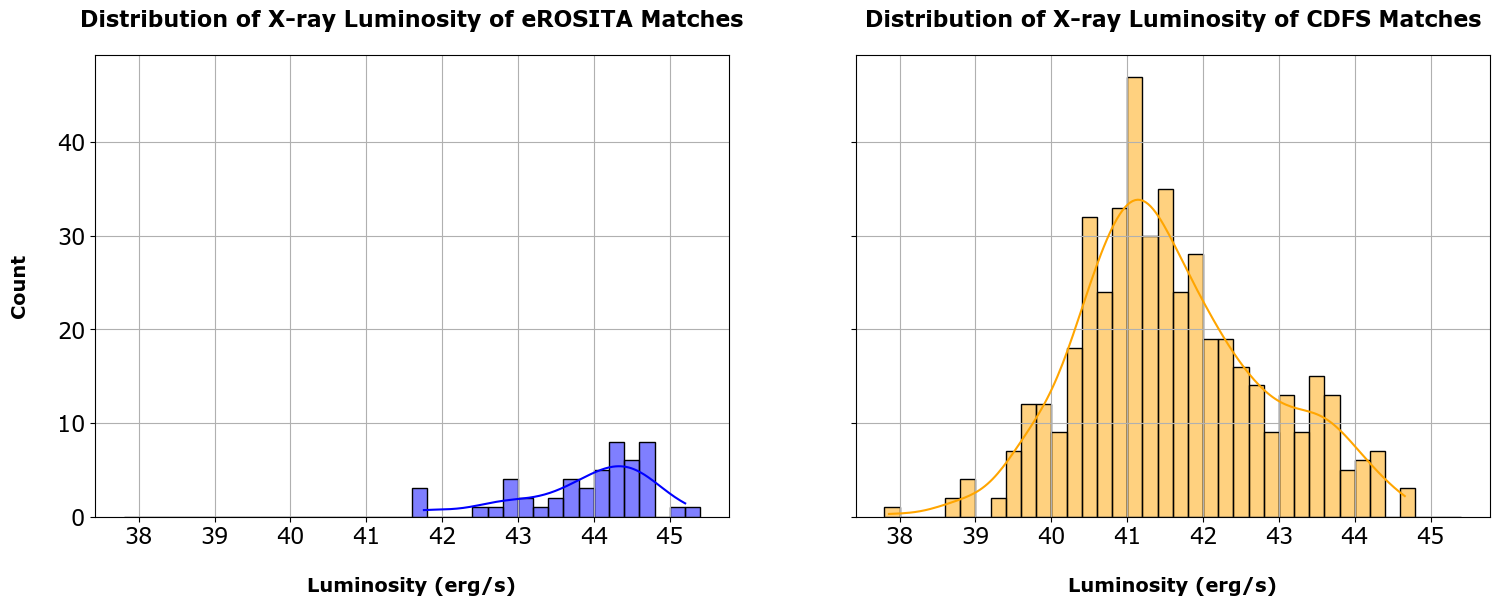

In [94]:
luminosity_erosita = edff_erosita_computed['L_x']
log_combined_luminosity_erosita = np.log10(luminosity_erosita[luminosity_erosita > 0])

luminosity_cdfs = edff_cdfs_computed['L_x']
log_combined_luminosity_cdfs = np.log10(luminosity_cdfs[luminosity_cdfs > 0])

min_log_lum = np.floor(min(log_combined_luminosity_erosita.min(), log_combined_luminosity_cdfs.min()) * 10) / 10
max_log_lum = np.ceil(max(log_combined_luminosity_erosita.max(), log_combined_luminosity_cdfs.max()) * 10) / 10
bin_edges = np.arange(min_log_lum, max_log_lum + 0.2, 0.2)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.histplot(log_combined_luminosity_erosita, bins=bin_edges, kde=True, ax=axes[0], color='blue')
axes[0].set_xlabel('Luminosity (erg/s)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of X-ray Luminosity of eROSITA Matches', fontsize=16,)
axes[0].grid(True)

sns.histplot(log_combined_luminosity_cdfs, bins=bin_edges, kde=True, ax=axes[1], color='orange')
axes[1].set_xlabel('Luminosity (erg/s)')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of X-ray Luminosity of CDFS Matches', fontsize=16)
axes[1].grid(True)

plt.savefig('plots/erosita_cdfs_xray_dist.png')
plt.show()

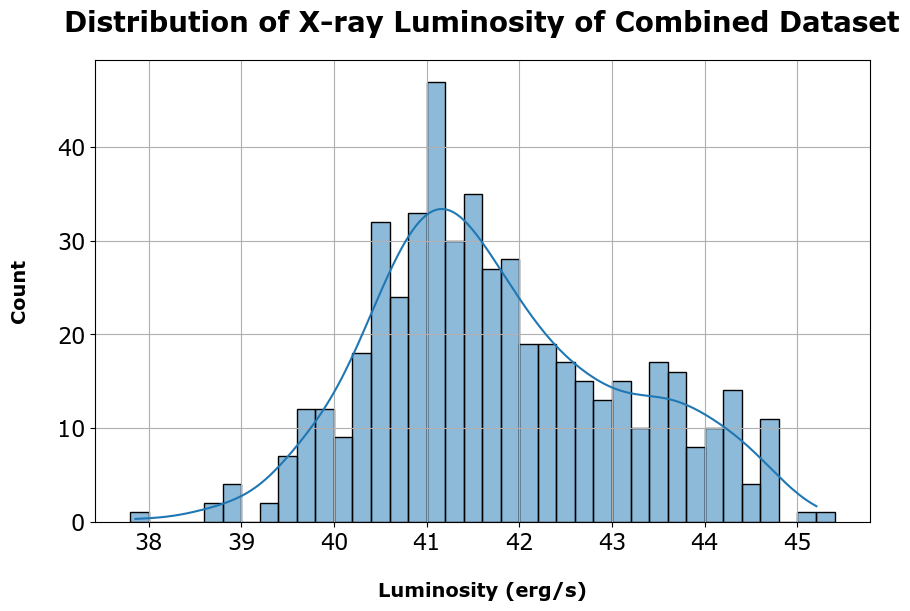

In [95]:
combined_luminosity = combined_computed['L_x']
log_combined_luminosity = np.log10(combined_luminosity[combined_luminosity > 0])

min_log_lum = np.floor(log_combined_luminosity.min() * 10) / 10
max_log_lum = np.ceil(log_combined_luminosity.max() * 10) / 10
bin_edges = np.arange(min_log_lum, max_log_lum + 0.2, 0.2)

plt.figure(figsize=(10, 6))
sns.histplot(log_combined_luminosity, bins=bin_edges, kde=True)
plt.xlabel('Luminosity (erg/s)')
plt.ylabel('Count')
plt.title('Distribution of X-ray Luminosity of Combined Dataset')
plt.grid(True)

plt.savefig('plots/combined_xray_dist.png')
plt.show()

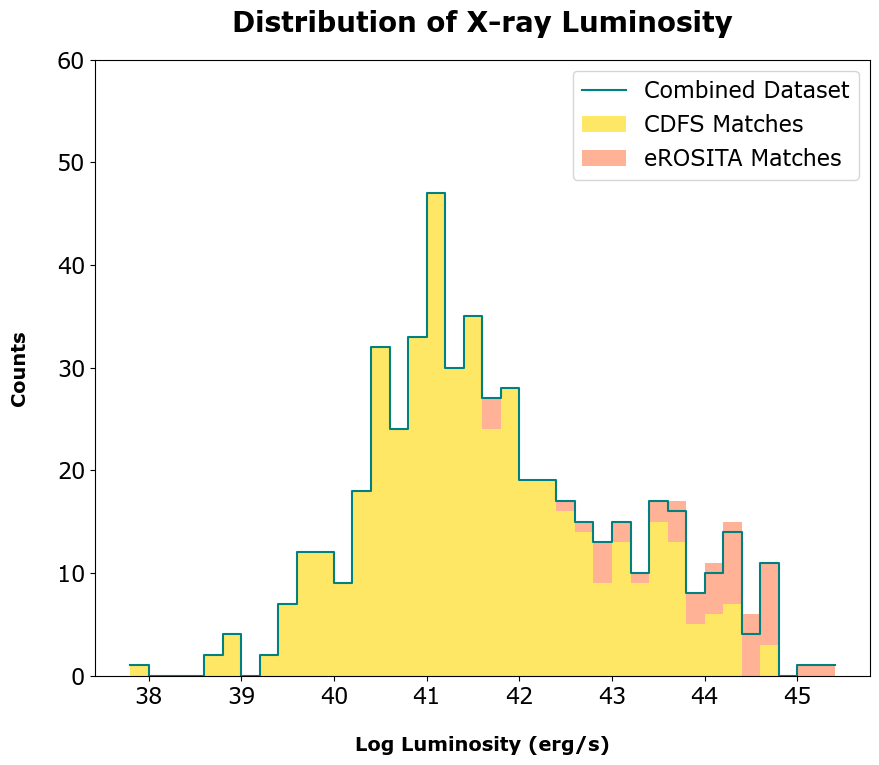

In [107]:
combined_luminosity = combined_computed['L_x']
log_combined_luminosity = np.log10(combined_luminosity[combined_luminosity > 0])

luminosity_erosita = edff_erosita_computed['L_x']
log_combined_luminosity_erosita = np.log10(luminosity_erosita[luminosity_erosita > 0])

luminosity_cdfs = edff_cdfs_computed['L_x']
log_combined_luminosity_cdfs = np.log10(luminosity_cdfs[luminosity_cdfs > 0])

min_log_lum = np.floor(min(log_combined_luminosity.min(), log_combined_luminosity_erosita.min(), log_combined_luminosity_cdfs.min()) * 10) / 10
max_log_lum = np.ceil(max(log_combined_luminosity.max(), log_combined_luminosity_erosita.max(), log_combined_luminosity_cdfs.max()) * 10) / 10
bin_edges = np.arange(min_log_lum, max_log_lum + 0.2, 0.2)

# Compute histogram counts
cdfs_counts, _ = np.histogram(log_combined_luminosity_cdfs, bins=bin_edges)
erosita_counts, _ = np.histogram(log_combined_luminosity_erosita, bins=bin_edges)

# Plotting
plt.figure(figsize=(10, 8))

# Plot the combined dataset as a line plot
sns.histplot(log_combined_luminosity, bins=bin_edges, kde=False, color='teal', label='Combined Dataset', fill=False, element='step', line_kws={'linewidth': 2})

# Plot the CDFS dataset
plt.bar(bin_edges[:-1], cdfs_counts, width=np.diff(bin_edges), color='gold', label='CDFS Matches', alpha=0.6, align='edge')

# Plot the eROSITA dataset on top of the CDFS dataset
plt.bar(bin_edges[:-1], erosita_counts, width=np.diff(bin_edges), bottom=cdfs_counts, color='coral', label='eROSITA Matches', alpha=0.6, align='edge')

plt.xlabel('Log Luminosity (erg/s)')
plt.ylabel('Counts')
plt.title('Distribution of X-ray Luminosity')
plt.legend()
plt.ylim(0, 60)

plt.savefig('plots/combined_erosita_cdfs_xray_dist.png')
plt.show()

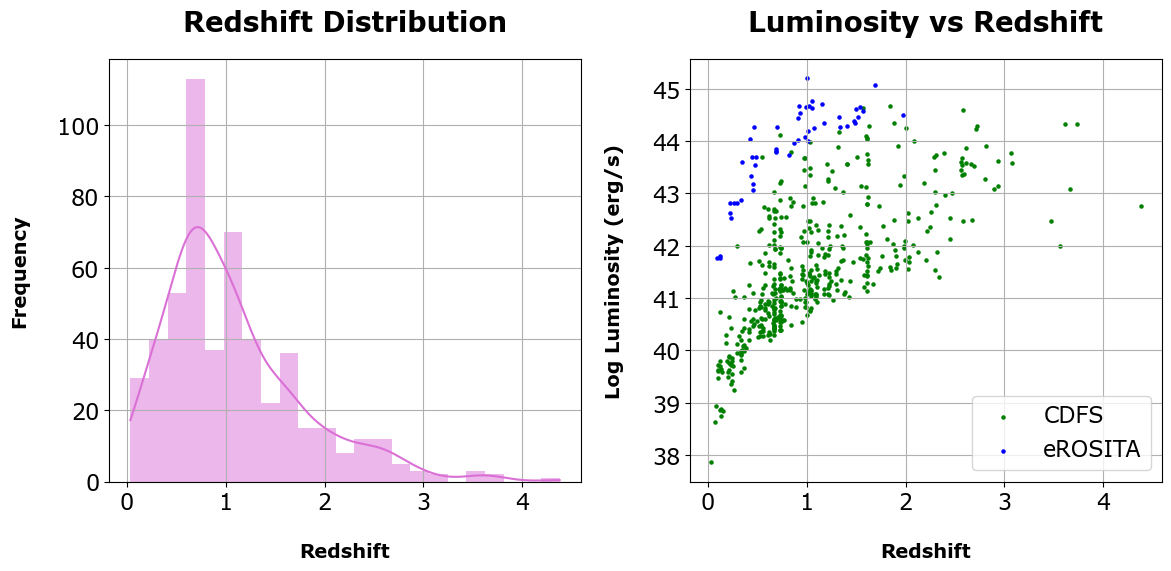

In [97]:
combined_redshifts = pd.concat([edff_cdfs_computed['z'], edff_erosita_computed['z']], ignore_index=True)
combined_luminosity = pd.concat([edff_cdfs_computed['L_x'], edff_erosita_computed['L_x']], ignore_index=True)

log_combined_luminosity = np.log10(combined_luminosity[combined_luminosity > 0])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(combined_redshifts, kde=True, ax=axes[0], edgecolor = "None", color='orchid')
axes[0].set_xlabel('Redshift')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Redshift Distribution')
axes[0].grid(True)

erosita_mask = combined_redshifts.index >= len(edff_cdfs_computed)
cdfs_mask = combined_redshifts.index < len(edff_cdfs_computed)

axes[1].scatter(combined_redshifts[cdfs_mask], log_combined_luminosity[cdfs_mask], label='CDFS', color='green', s=5)
axes[1].scatter(combined_redshifts[erosita_mask], log_combined_luminosity[erosita_mask], label='eROSITA', color='blue', s=5)

axes[1].set_xlabel('Redshift')
axes[1].set_ylabel('Log Luminosity (erg/s)')
axes[1].set_title('Luminosity vs Redshift')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('plots/erosita_cdfs_redshift_dist.png')
plt.show()


CDFS - Above threshold: 102 Below threshold: 366
eROSITA - Above threshold: 47 Below threshold: 3


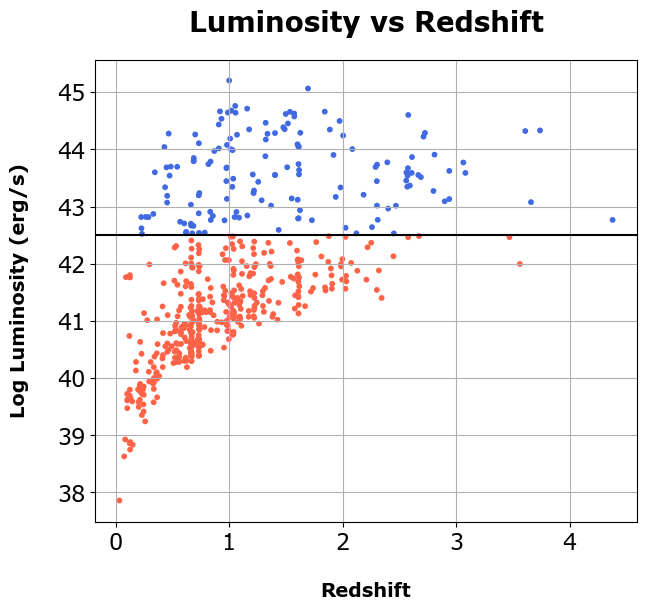

In [98]:
combined_redshifts = pd.concat([edff_cdfs_computed['z'], edff_erosita_computed['z']], ignore_index=True)
combined_luminosity = pd.concat([edff_cdfs_computed['L_x'], edff_erosita_computed['L_x']], ignore_index=True)

log_combined_luminosity = np.log10(combined_luminosity[combined_luminosity > 0])

fig, ax = plt.subplots(figsize=(7, 6))

erosita_mask = combined_redshifts.index >= len(edff_cdfs_computed)
cdfs_mask = combined_redshifts.index < len(edff_cdfs_computed)

color_below = 'tomato'
color_above = 'royalblue'

luminosity_threshold = 42.5

cdfs_colors = np.where(log_combined_luminosity[cdfs_mask] > luminosity_threshold, color_above, color_below)
ax.scatter(combined_redshifts[cdfs_mask], log_combined_luminosity[cdfs_mask], label='CDFS', c=cdfs_colors, s=10)

erosita_colors = np.where(log_combined_luminosity[erosita_mask] > luminosity_threshold, color_above, color_below)
ax.scatter(combined_redshifts[erosita_mask], log_combined_luminosity[erosita_mask], label='eROSITA', c=erosita_colors, s=10)

ax.axhline(y=42.5, color='black', linestyle='-')

ax.set_xlabel('Redshift')
ax.set_ylabel('Log Luminosity (erg/s)')
ax.set_title('Luminosity vs Redshift')
ax.grid(True)

# Count and print the number of points above and below the threshold
cdfs_above_threshold = np.sum(log_combined_luminosity[cdfs_mask] > luminosity_threshold)
cdfs_below_threshold = np.sum(log_combined_luminosity[cdfs_mask] <= luminosity_threshold)
erosita_above_threshold = np.sum(log_combined_luminosity[erosita_mask] > luminosity_threshold)
erosita_below_threshold = np.sum(log_combined_luminosity[erosita_mask] <= luminosity_threshold)

print("CDFS - Above threshold:", cdfs_above_threshold, "Below threshold:", cdfs_below_threshold)
print("eROSITA - Above threshold:", erosita_above_threshold, "Below threshold:", erosita_below_threshold)

plt.savefig('plots/erosita_cdfs_redshift_dist.png')
plt.show()

## SED Analysis

In [99]:
def generate_sed(df, threshold = 10**(42.5)):
    sed_dicts = []
    for _, row in df.iterrows():
        if row['L_x'] < threshold:
            continue  # Skip this row if L_x is below the threshold
        
        wavelengths_rest = np.array([wavelength_dict[w] / (1e4 * (1 + row['z'])) for w in wavelength_dict])
        luminosities = row[['L_x','L_u', 'L_g', 'L_r', 'L_i', 'L_z', 'L_ch1', 'L_ch2']].values
        fluxes = row[['F_x','F_u', 'F_g', 'F_r', 'F_i', 'F_z', 'F_ch1', 'F_ch2']].values
        edffID = row['edffID']
        redshift = row['z']
        sed_data_dict = {
            'wavelength': wavelengths_rest,
            'L' : np.log10(luminosities),
            'F': np.log10(fluxes),
            'edffID': edffID,
            'redshift': redshift, 
        }
        sed_dicts.append(sed_data_dict)
    return sed_dicts


def plot_sed(normalized_sed_dicts, ax_flux, ax_lum, cmap, vmin, vmax):
    for sed_dict in normalized_sed_dicts:
        color = cmap((sed_dict['L'][0]) - vmin) / (vmax - vmin)
        ax_flux.plot(sed_dict['wavelength'][1:], sed_dict['F'][1:], color=color, linewidth=0.5)
        ax_lum.plot(sed_dict['wavelength'][1:], sed_dict['L'][1:], color=color, linewidth=0.5)

combined_sed_dicts = generate_sed(combined_computed)
edff_cdfs_sed_dicts = generate_sed(edff_cdfs_computed)
edff_erosita_sed_dicts = generate_sed(edff_erosita_computed)


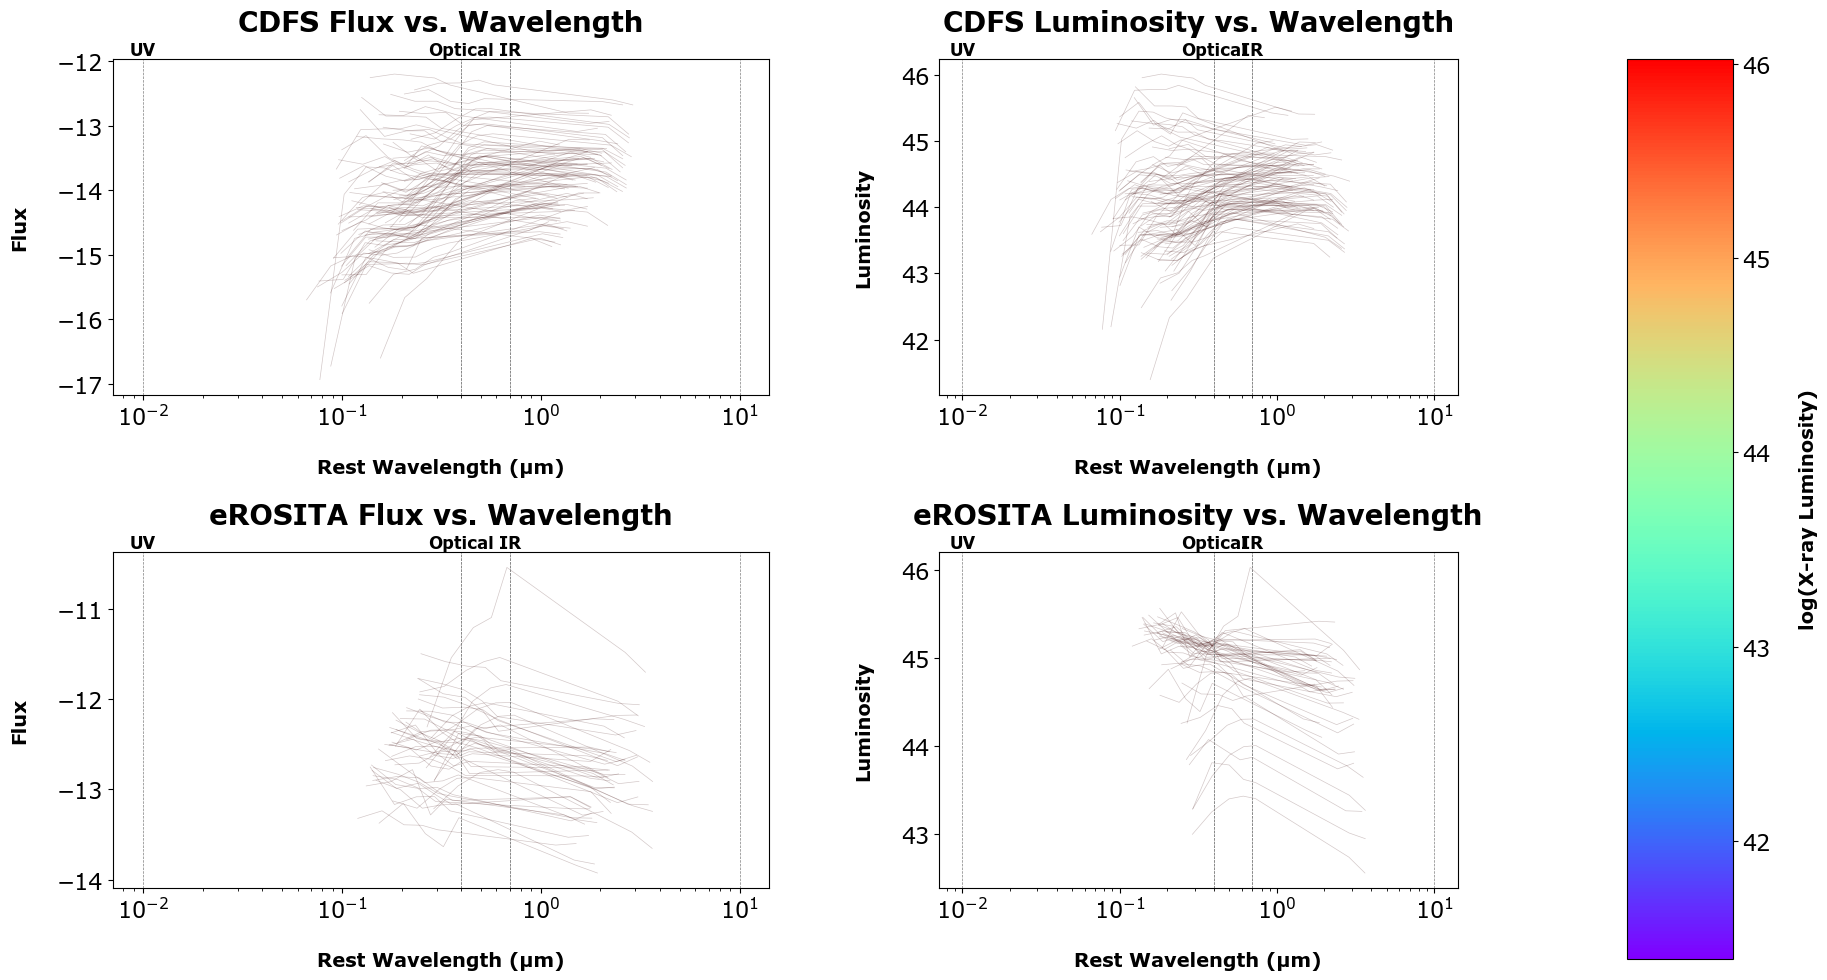

In [100]:
log_L_values = [sed['L'] for sed in combined_sed_dicts]
vmin = np.min(log_L_values[1:])
vmax = np.max(log_L_values[1:])
cmap = plt.get_cmap('rainbow')

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(13, 12, figure=fig) 

axs = [
    fig.add_subplot(gs[0:5, 0:5]), 
    fig.add_subplot(gs[0:5, 6:10]),  
    fig.add_subplot(gs[7:12, 0:5]), 
    fig.add_subplot(gs[7:12, 6:10])   
]

plot_sed(edff_cdfs_sed_dicts, axs[0], axs[1], cmap, vmin, vmax)
plot_sed(edff_erosita_sed_dicts, axs[2], axs[3], cmap, vmin, vmax)

for ax in axs:
    ax.set_xscale('log')

title_padding = 20

axs[0].set_xlabel('Rest Wavelength (μm)')
axs[0].set_ylabel('Flux')
axs[0].set_title('CDFS Flux vs. Wavelength', pad=title_padding)

axs[1].set_xlabel('Rest Wavelength (μm)')
axs[1].set_ylabel('Luminosity')
axs[1].set_title('CDFS Luminosity vs. Wavelength', pad=title_padding)

axs[2].set_xlabel('Rest Wavelength (μm)')
axs[2].set_ylabel('Flux')
axs[2].set_title('eROSITA Flux vs. Wavelength', pad=title_padding)

axs[3].set_xlabel('Rest Wavelength (μm)')
axs[3].set_ylabel('Luminosity')
axs[3].set_title('eROSITA Luminosity vs. Wavelength', pad=title_padding)


wavelength_labels = [
    ('UV', 0.01, 0.4),
    ('Optical', 0.4, 0.7),
    ('IR', 0.7, 10)
]

for ax in axs:
    for label, start, end in wavelength_labels:
        ax.text(start, ax.get_ylim()[1] * 1, label, ha='center', va='bottom', fontsize=12, fontweight='bold')
        ax.axvline(x=start, color='gray', linestyle='--', linewidth=0.5)
        ax.axvline(x=end, color='gray', linestyle='--', linewidth=0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar_ax = fig.add_subplot(gs[:, 11])  # Adjusted to use only one column
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('log(X-ray Luminosity)')

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)
plt.savefig('plots/erosita_cdfs_seds.png')
plt.show()

In [101]:
def normalize_sed_at_wavelength(sed_dicts, norm_wavelength=1):
    normalized_sed_dicts = []
    for sed_dict in sed_dicts:
        interp_flux = interp1d(sed_dict['wavelength'][1:], sed_dict['F'][1:], kind='linear', fill_value="extrapolate")
        interp_lum = interp1d(sed_dict['wavelength'][1:], sed_dict['L'][1:], kind='linear', fill_value="extrapolate")
        
        norm_flux = interp_flux(norm_wavelength)
        norm_luminosity = interp_lum(norm_wavelength)

        normalized_fluxes = sed_dict['F'] / norm_flux
        normalized_luminosities = sed_dict['L'] / norm_luminosity

        normalized_sed_data_dict = {
            'wavelength': sed_dict['wavelength'],
            'L': normalized_luminosities,
            'F': normalized_fluxes,
            'edffID': sed_dict['edffID'],
            'redshift': sed_dict['redshift'],
            'original_L': sed_dict['L']  # Keep the original luminosity for coloring
        }
        normalized_sed_dicts.append(normalized_sed_data_dict)
    return normalized_sed_dicts

def get_median_sed(normalized_sed_dicts, threshold=1):
    all_wavelengths = np.unique(np.concatenate([sed_dict['wavelength'] for sed_dict in normalized_sed_dicts]))
    median_luminosities = []
    valid_wavelengths = []

    for wavelength in all_wavelengths:
        luminosities_at_wavelength = []
        for sed_dict in normalized_sed_dicts:
            interp_lum = interp1d(sed_dict['wavelength'][1:], sed_dict['L'][1:], kind='linear', bounds_error=False, fill_value=np.nan)
            luminosities_at_wavelength.append(interp_lum(wavelength))
        
        valid_luminosities = [lum for lum in luminosities_at_wavelength if not np.isnan(lum)]
        if len(valid_luminosities) >= threshold * len(normalized_sed_dicts):
            valid_wavelengths.append(wavelength)
            median_luminosities.append(np.nanmedian(valid_luminosities))
    
    median_sed_dict = {
        'wavelength': valid_wavelengths,
        'L': median_luminosities,
    }
    return median_sed_dict

def plot_normalized_sed(normalized_sed_dicts, ax_lum, cmap, vmin, vmax):
    for sed_dict in normalized_sed_dicts:
        color = cmap((sed_dict['original_L'][0] - vmin) / (vmax - vmin))
        ax_lum.plot(sed_dict['wavelength'][1:], sed_dict['L'][1:], color=color, linewidth=0.5)
    
    median_sed_dict = get_median_sed(normalized_sed_dicts)
    ax_lum.plot(median_sed_dict['wavelength'][1:], median_sed_dict['L'][1:], color='black', linewidth=2, label='Median')
    ax_lum.legend()

In [102]:
norm_wavelength = 1

normalized_combined_sed_dicts = normalize_sed_at_wavelength(combined_sed_dicts, norm_wavelength)
normalized_edff_cdfs_sed_dicts = normalize_sed_at_wavelength(edff_cdfs_sed_dicts, norm_wavelength)
normalized_edff_erosita_sed_dicts = normalize_sed_at_wavelength(edff_erosita_sed_dicts, norm_wavelength)

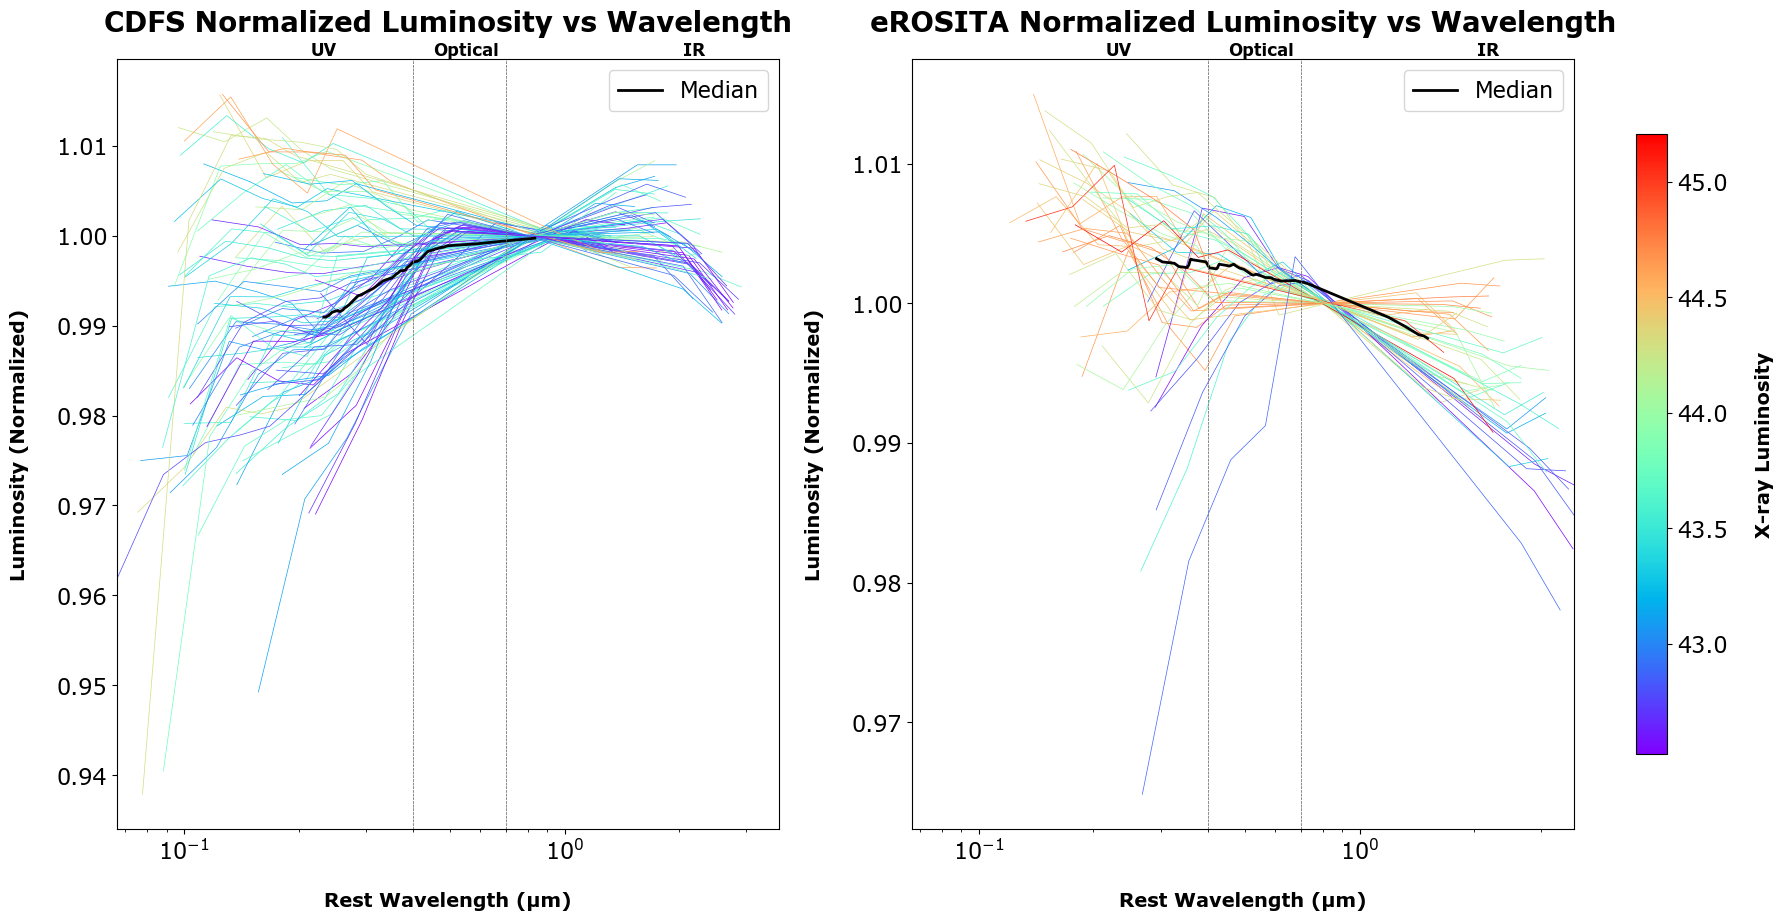

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

log_L_values = [sed['L'][0] for sed in combined_sed_dicts]
vmin = np.min(log_L_values)
vmax = np.max(log_L_values)
cmap = plt.get_cmap('rainbow')

plot_normalized_sed(normalized_edff_cdfs_sed_dicts, axs[0], cmap, vmin, vmax)
plot_normalized_sed(normalized_edff_erosita_sed_dicts, axs[1], cmap, vmin, vmax)

for ax in axs.flatten():
    all_wavelengths = [w for sed in normalized_edff_cdfs_sed_dicts + normalized_edff_erosita_sed_dicts for w in sed['wavelength'][1:]]
    x_min, x_max = min(all_wavelengths), max(all_wavelengths)
    ax.set_xlim(x_min, x_max)
    
    ax.set_xscale('log')

axs[0].set_xlabel('Rest Wavelength (μm)')
axs[0].set_ylabel('Luminosity (Normalized)')
axs[0].set_title('CDFS Normalized Luminosity vs Wavelength')

axs[1].set_xlabel('Rest Wavelength (μm)')
axs[1].set_ylabel('Luminosity (Normalized)')
axs[1].set_title('eROSITA Normalized Luminosity vs Wavelength')

wavelength_labels = [
    ('UV', 0.01, 0.4),
    ('Optical', 0.4, 0.7),
    ('IR', 0.7, 10)
]

for ax in axs.flatten():
    for label, start, end in wavelength_labels:
        if start >= x_min and end <= x_max:
            ax.axvline(x=start, color='gray', linestyle='--', linewidth=0.5)
            ax.axvline(x=end, color='gray', linestyle='--', linewidth=0.5)
            y_pos = ax.get_ylim()[1] * 1
            ax.text((start + end) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')
        else:
            if start < x_min < end:
                ax.axvline(x=x_min, color='gray', linestyle='--', linewidth=0.5)
                ax.axvline(x=end, color='gray', linestyle='--', linewidth=0.5)
                y_pos = ax.get_ylim()[1] * 1
                ax.text((x_min + end) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')
            elif start < x_max < end:
                ax.axvline(x=start, color='gray', linestyle='--', linewidth=0.5)
                ax.axvline(x=x_max, color='gray', linestyle='--', linewidth=0.5)
                y_pos = ax.get_ylim()[1] * 1 
                ax.text((start + x_max) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs[:], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('X-ray Luminosity')

plt.savefig('plots/erosita_cdfs_seds_median.png')
plt.show()

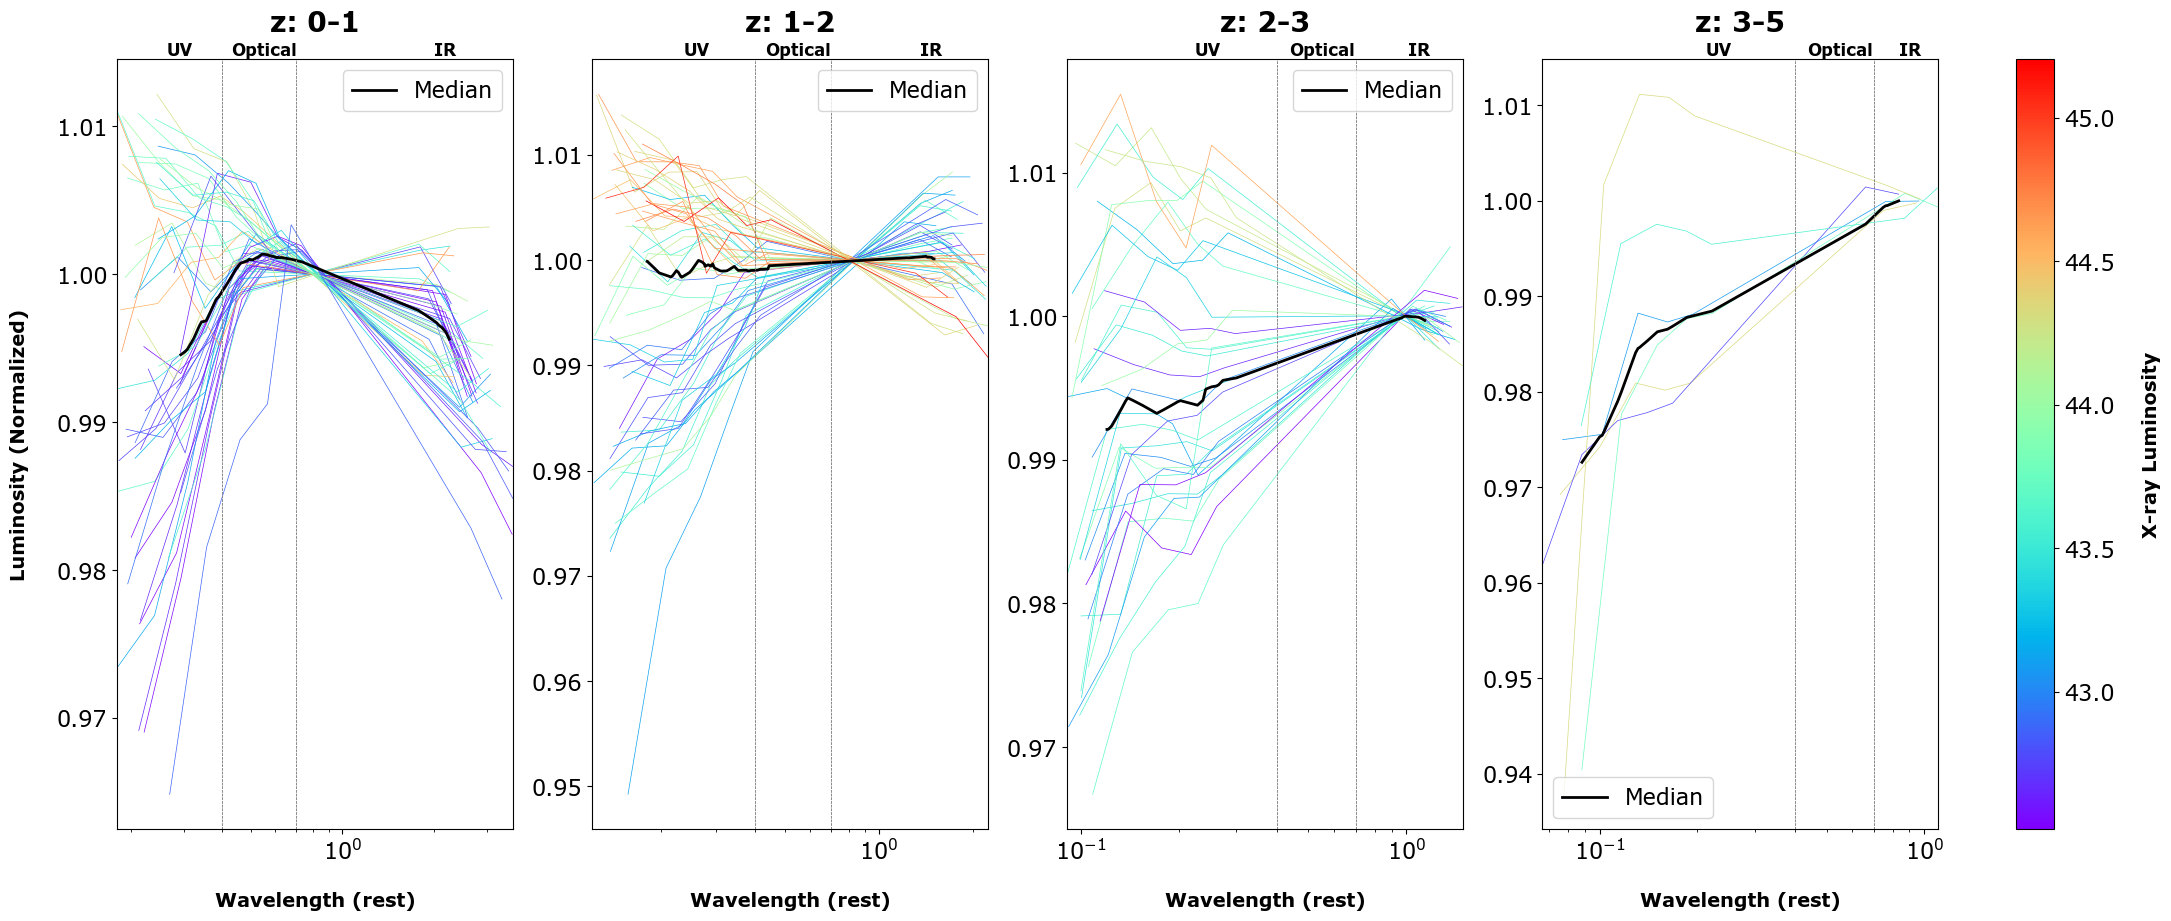

In [104]:
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 5)]

fig, axs = plt.subplots(1, 4, figsize=(25, 10))

log_L_values = [sed['L'][0] for sed in combined_sed_dicts]
vmin = np.min(log_L_values)
vmax = np.max(log_L_values)
cmap = plt.get_cmap('rainbow')

for i, (z_min, z_max) in enumerate(redshift_bins):
    ax_lum = axs[i]
    sed_bin = [sed_dict for sed_dict in normalized_combined_sed_dicts if z_min <= sed_dict['redshift'] < z_max]
    plot_normalized_sed(sed_bin, ax_lum, cmap, vmin, vmax)
    
    all_wavelengths = [w for sed in sed_bin for w in sed['wavelength'][1:]]
    x_min, x_max = min(all_wavelengths), max(all_wavelengths)
    ax_lum.set_xlim(x_min, x_max)
    
    ax_lum.set_xscale('log')
    ax_lum.set_xlabel('Wavelength (rest)')
    if i == 0:
        ax_lum.set_ylabel('Luminosity (Normalized)')
    ax_lum.set_title(f'z: {z_min}-{z_max}')
    ax_lum.title.paddding = 40

    wavelength_labels = [
        ('UV', 0.01, 0.4),
        ('Optical', 0.4, 0.7),
        ('IR', 0.7, 10)
    ]

    for label, start, end in wavelength_labels:
        if start >= x_min and end <= x_max:
            ax_lum.axvline(x=start, color='gray', linestyle='--', linewidth=0.5)
            ax_lum.axvline(x=end, color='gray', linestyle='--', linewidth=0.5)
            y_pos = ax_lum.get_ylim()[1] * 1  # Adjust this factor as needed
            ax_lum.text((start + end) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')
        else:
            if start < x_min < end:
                ax_lum.axvline(x=x_min, color='gray', linestyle='--', linewidth=0.5)
                ax_lum.axvline(x=end, color='gray', linestyle='--', linewidth=0.5)
                y_pos = ax_lum.get_ylim()[1] * 1  # Adjust this factor as needed
                ax_lum.text((x_min + end) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')
            elif start < x_max < end:
                ax_lum.axvline(x=start, color='gray', linestyle='--', linewidth=0.5)
                ax_lum.axvline(x=x_max, color='gray', linestyle='--', linewidth=0.5)
                y_pos = ax_lum.get_ylim()[1] * 1  # Adjust this factor as needed
                ax_lum.text((start + x_max) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs[:], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('X-ray Luminosity')

plt.savefig('plots/combined_seds_redshift_bins.png')
plt.show()

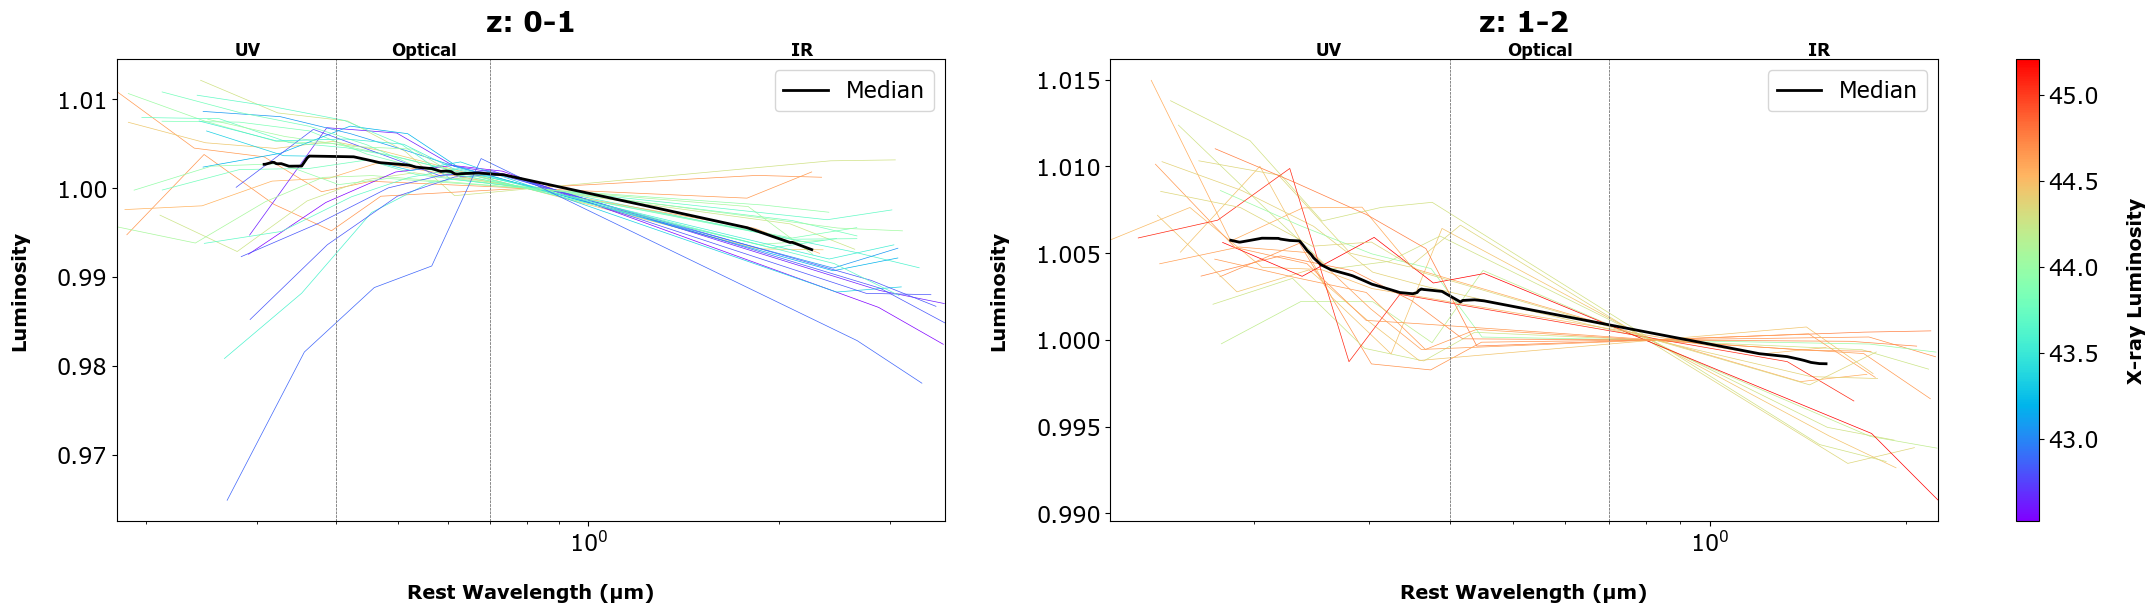

In [105]:
redshift_bins = [(0, 1), (1, 2)]

fig, axs = plt.subplots(1, 2, figsize=(25, 6))

log_L_values = [sed['L'][0] for sed in combined_sed_dicts]
vmin = np.min(log_L_values)
vmax = np.max(log_L_values)
cmap = plt.get_cmap('rainbow')

for i, (z_min, z_max) in enumerate(redshift_bins):
    ax_lum = axs[i]
    sed_bin = [sed_dict for sed_dict in normalized_edff_erosita_sed_dicts if z_min <= sed_dict['redshift'] < z_max]
    plot_normalized_sed(sed_bin, ax_lum, cmap, vmin, vmax)
    
    # Calculate x-limits based on the SED data
    all_wavelengths = [w for sed in sed_bin for w in sed['wavelength'][1:]]
    x_min, x_max = min(all_wavelengths), max(all_wavelengths)
    ax_lum.set_xlim(x_min, x_max)
    
    ax_lum.set_xscale('log')
    ax_lum.set_xlabel('Rest Wavelength (μm)')
    ax_lum.set_ylabel('Luminosity')
    ax_lum.set_title(f'z: {z_min}-{z_max}')

    # Define wavelength regions
    wavelength_labels = [
        ('UV', 0.01, 0.4),
        ('Optical', 0.4, 0.7),
        ('IR', 0.7, 10)
    ]

    for label, start, end in wavelength_labels:
        if start >= x_min and end <= x_max:
            ax_lum.axvline(x=start, color='gray', linestyle='--', linewidth=0.5)
            ax_lum.axvline(x=end, color='gray', linestyle='--', linewidth=0.5)
            y_pos = ax_lum.get_ylim()[1] * 1  # Adjust this factor as needed
            ax_lum.text((start + end) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')
        else:
            # If the region is partially within the x-limits, adjust the label position
            if start < x_min < end:
                ax_lum.axvline(x=x_min, color='gray', linestyle='--', linewidth=0.5)
                ax_lum.axvline(x=end, color='gray', linestyle='--', linewidth=0.5)
                y_pos = ax_lum.get_ylim()[1] * 1  # Adjust this factor as needed
                ax_lum.text((x_min + end) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')
            elif start < x_max < end:
                ax_lum.axvline(x=start, color='gray', linestyle='--', linewidth=0.5)
                ax_lum.axvline(x=x_max, color='gray', linestyle='--', linewidth=0.5)
                y_pos = ax_lum.get_ylim()[1] * 1  # Adjust this factor as needed
                ax_lum.text((start + x_max) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs[:], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('X-ray Luminosity')

plt.savefig('plots/erosita_seds_redshift_bins.png')
plt.show()

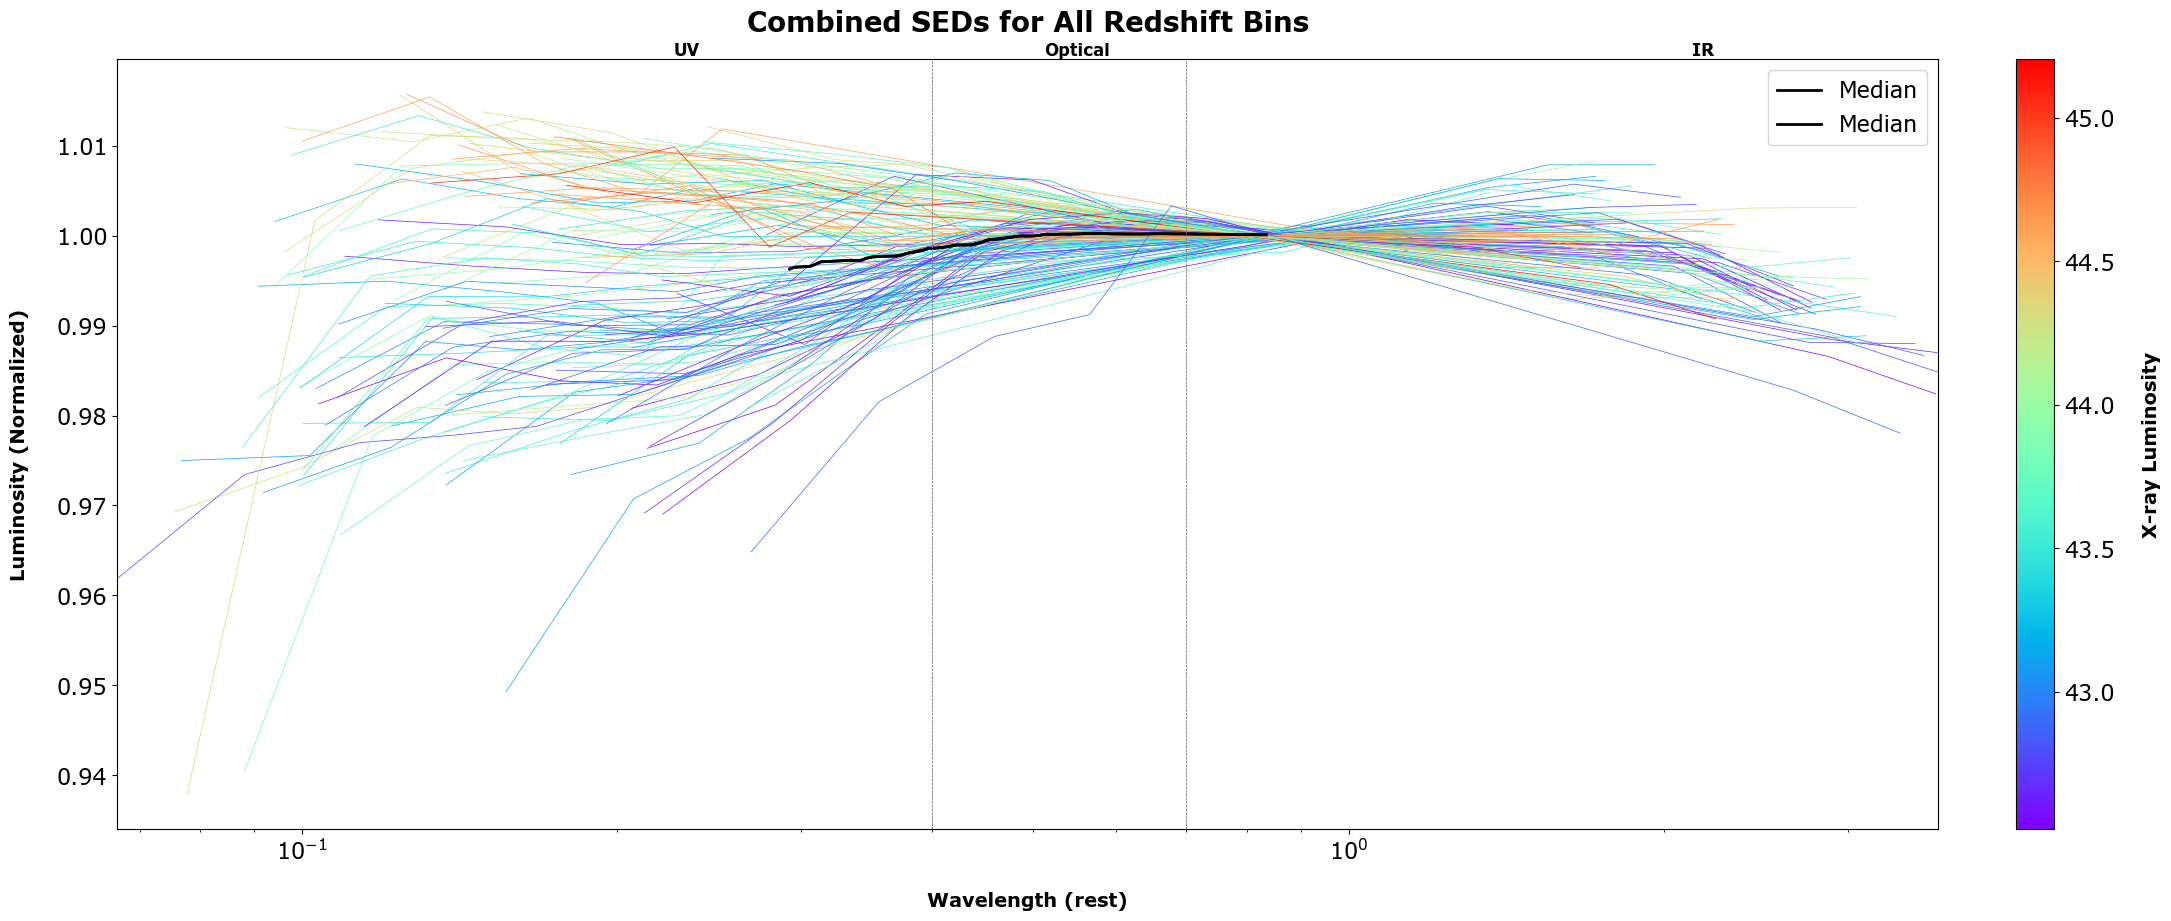

In [106]:

def plot_all_seds(normalized_combined_sed_dicts):
    fig, ax = plt.subplots(figsize=(25, 10))

    log_L_values = [sed['original_L'][0] for sed in normalized_combined_sed_dicts]
    vmin = np.min(log_L_values)
    vmax = np.max(log_L_values)
    cmap = plt.get_cmap('rainbow')

    plot_normalized_sed(normalized_combined_sed_dicts, ax, cmap, vmin, vmax)

    # Plot the median SED
    median_sed_dict = get_median_sed(normalized_combined_sed_dicts)
    ax.plot(median_sed_dict['wavelength'][1:], median_sed_dict['L'][1:], color='black', linewidth=2, label='Median')
    ax.legend()

    # Set x-axis limits
    all_wavelengths = [w for sed in normalized_combined_sed_dicts for w in sed['wavelength'][1:]]
    x_min, x_max = min(all_wavelengths), max(all_wavelengths)
    ax.set_xlim(x_min, x_max)

    ax.set_xscale('log')
    ax.set_xlabel('Wavelength (rest)')
    ax.set_ylabel('Luminosity (Normalized)')
    ax.set_title('Combined SEDs for All Redshift Bins')

    wavelength_labels = [
        ('UV', 0.01, 0.4),
        ('Optical', 0.4, 0.7),
        ('IR', 0.7, 10)
    ]

    for label, start, end in wavelength_labels:
        if start >= x_min and end <= x_max:
            ax.axvline(x=start, color='gray', linestyle='--', linewidth=0.5)
            ax.axvline(x=end, color='gray', linestyle='--', linewidth=0.5)
            y_pos = ax.get_ylim()[1] * 1  # Adjust this factor as needed
            ax.text((start + end) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')
        else:
            if start < x_min < end:
                ax.axvline(x=x_min, color='gray', linestyle='--', linewidth=0.5)
                ax.axvline(x=end, color='gray', linestyle='--', linewidth=0.5)
                y_pos = ax.get_ylim()[1] * 1  # Adjust this factor as needed
                ax.text((x_min + end) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')
            elif start < x_max < end:
                ax.axvline(x=start, color='gray', linestyle='--', linewidth=0.5)
                ax.axvline(x=x_max, color='gray', linestyle='--', linewidth=0.5)
                y_pos = ax.get_ylim()[1] * 1  # Adjust this factor as needed
                ax.text((start + x_max) / 2, y_pos, label, ha='center', va='bottom', fontsize=12, fontweight='bold')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('X-ray Luminosity')

    plt.savefig('plots/combined_seds_all_redshift_bins.png')
    plt.show()

# Example usage
normalized_combined_sed_dicts = normalize_sed_at_wavelength(combined_sed_dicts)
plot_all_seds(normalized_combined_sed_dicts)

## To Do
* Plot redshift bins
* remove x-ray 
* Normalized at 1 micron
* plot luminosity bins
* Plot Individual SEDs
* Maybe plot median line

## Other options
* Machine Learning
* Preliminary Cigale fit 
